[View in Colaboratory](https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/mnist.ipynb)

In [81]:
!pip3 install torch torchvision

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
batch_size=64
num_workers=1

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  img = np.array([img, img, img])
  return torch.from_numpy(img)

In [0]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

0


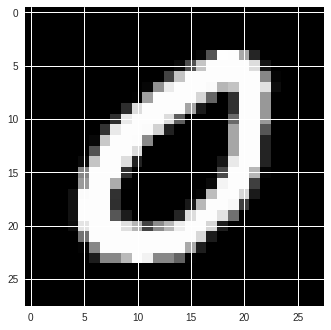

In [88]:
import matplotlib.pyplot as plt

trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
class MnistNET(nn.Module):
  def __init__(self):
    super(MnistNET, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
    x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)    
  

In [0]:
criterion = F.nll_loss

In [0]:
log_interval = 100
epochs = 5
use_cuda = True

In [0]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1] 
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
model = MnistNET().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [97]:
for epoch in range(1, epochs+1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.351737
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.728377
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.440051
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.515165
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.328663
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.448558
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.328686
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.248726
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.188571
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.342227

Test set: Average loss: 0.0963, Accuracy: 9702/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.271865
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.183371
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.149252
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.280538
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.282320
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.401330
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.253120
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.377230
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.067913
T

In [0]:
def printIncorrect(model, set):
  print_img = 6
  fig = plt.figure()
  for sample in set:
    inp = sample[0].unsqueeze(0)
    out = model(inp.to(device)).max(1)[1][0]
    if out != sample[1].to(device):

      plt.subplot(2,3,7 - print_img)
      plt.tight_layout()
      image = sample[0]
      image = image.numpy()
      image = image * 0.3081 + 0.1307
      plt.imshow(image.transpose(1,2,0), cmap='gray')
      plt.title("Ground Truth: {} Pred: {}".format(sample[1], out))
      plt.xticks([])
      plt.yticks([])

      print_img -= 1
      if print_img == 0: break



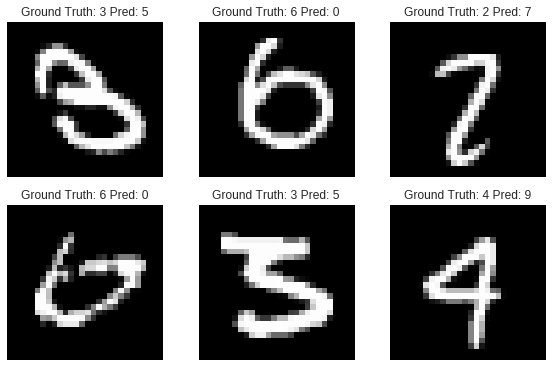

In [99]:
printIncorrect(model, test_set)

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!ls "drive/My Drive"

In [0]:
import pickle

In [0]:
class Mnist_M(torch.utils.data.Dataset):
  
  def __init__(self, train=True, transform=None):
    
    self.train = train
    self.transform = transform
    
    with open('drive/My Drive/keras_mnistm.pkl', 'rb') as mnist_m:
      mnist_m_data = pickle.load(mnist_m, encoding='bytes')
    mnist_m_train_data = torch.ByteTensor(mnist_m_data[b'train'])
    mnist_m_test_data = torch.ByteTensor(mnist_m_data[b'test'])
    if train:
      mnist_m_train_labels = torchvision.datasets.MNIST(
          root='./data', train=True, download=True).train_labels
      self.mnist_m_set = list(zip(mnist_m_train_data, mnist_m_train_labels))
    else:
      mnist_m_test_labels = torchvision.datasets.MNIST(
          root='./data', train=False, download=True).test_labels
      self.mnist_m_set = list(zip(mnist_m_test_data, mnist_m_test_labels))
    self.len = len(self.mnist_m_set)
  
  def __len__(self):
    return self.len
  
  def __getitem__(self, index):
    label = self.mnist_m_set[index][1]
    sample = self.mnist_m_set[index][0].permute(2,0,1).float()
    sample = sample / 255
    
    if self.transform: 
      #sample = self.transform(sample)
      sample = (sample - 0.1307) / 0.3081
      
    return (sample, label)

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ])
mnist_m_train = Mnist_M(transform=mnist_m_transform)
mnist_m_test = Mnist_M(train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


tensor(6)


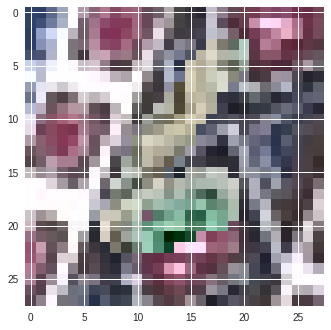

In [105]:
trainiter = iter(mnist_m_train_loader)
images, labels = trainiter.next()
printMnist3D(images[0])
print(labels[0])

In [106]:
test(model, device, mnist_m_test_loader)


Test set: Average loss: 1.4686, Accuracy: 5143/10000 (51%)



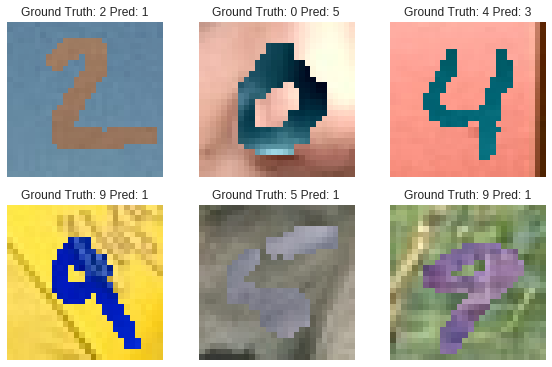

In [107]:
printIncorrect(model, mnist_m_test)

In [0]:
class Mnist_Ext(torch.utils.data.Dataset):
  def __init__(self, datasets):
    self.datasets = datasets
    self.lengths = [len(ds) for ds in datasets]
    self.offsets = np.cumsum(self.lengths)
    self.len = np.sum(self.lengths)
    
  def __len__(self):
    return self.len
  
  def __getitem__(self, index):
    for dset_num, dset_offset in enumerate(self.offsets):
      if index < dset_offset:
        index -= np.append([0], self.offsets)[dset_num]
        sample, label = self.datasets[dset_num][index]
        domain = torch.tensor(dset_num).float()
        return (sample, (label, domain))
  

In [0]:
mnist_ext_train = Mnist_Ext([train_set, mnist_m_train])
mnist_ext_test = Mnist_Ext([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)



tensor([0., 1.])


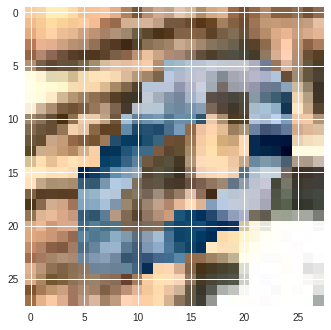

In [110]:
trainiter = iter(mnist_ext_train_loader)
images, labels = trainiter.next()
labels = torch.tensor(list(zip(labels[0], labels[1])))
printMnist3D(images[0])
print(labels[0])

In [111]:
train_loader.dataset.__len__()

60000

In [0]:
class GradReverse(torch.autograd.Function):
    def __init__(self, lambd=1.):
      self.lambd = lambd
    
    def forward(self, x):
        return x.view_as(x)

    def backward(self, grad_output):
        return (grad_output * -self.lambd)

def grad_reverse(x, lambd):
    return GradReverse(lambd)(x)

In [0]:
class MnistDomain(nn.Module):
  def __init__(self):
    super(MnistDomain, self).__init__()
    self.fc1 = nn.Linear(320, 100)
    self.fc2 = nn.Linear(100, 1)

  def forward(self, x, lambd=1.):
    x = grad_reverse(x, lambd)
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return torch.sigmoid(x)
    

In [0]:
class MnistFeatureExtractor(nn.Module):
  def __init__(self):
    super(MnistFeatureExtractor, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
  def forward(self, x):
    x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
    x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    return x.view(-1, 320) 

In [0]:
class MnistClassPredictor(nn.Module):
  def __init__(self):
    super(MnistClassPredictor, self).__init__()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)    

In [0]:
criterion = F.nll_loss
criterion_domain = F.binary_cross_entropy

In [0]:
def trainWithDomain(model_f, model_c, model_d, device, train_loader_class, 
                    train_loader_domain, optim_f, optim_c, optim_d, 
                    epoch, epochs, use_lambd=True, train_domain=True):
  model_f.train()
  model_c.train()
  model_d.train()
  if train_domain:
    domain_iter = iter(train_loader_domain)
  lambd = -1.
  batch_num = len(train_loader.dataset) / train_loader.batch_size
  for batch_idx, (data, labels) in enumerate(train_loader):
    
    p = ((epoch-1) * batch_num + batch_idx) / (epochs * batch_num)
    lr = 0.01 / (1. + 10. * p)**0.75
    optim_f.lr = lr
    optim_c.lr = lr
    optim_d.lr = lr
    
    data = data.to(device)
    labels = labels.to(device)
    optim_f.zero_grad()
    optim_c.zero_grad()
    output = model_c(model_f(data))
    loss = criterion(output, labels)
    loss.backward()
    
    optim_f.step()
    optim_c.step()
    if train_domain:
      data, (_, domains) = domain_iter.next()
      data, domains = data.to(device), domains.unsqueeze(1).to(device)
      optim_f.zero_grad()
      optim_d.zero_grad()
      
      if use_lambd:
        lambd = 2. / (1. + np.exp(-10. * p)) - 1.   
      else:
        lambd = 1.
      output = model_d(model_f(data), lambd)
      loss_domain = criterion_domain(output, domains)
      loss_domain.backward()
      optim_f.step()
      optim_d.step()
    
    if batch_idx % log_interval == 0:
        print('Train Epoch: \
              {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, lr: {:.5f} lambd: {:.5f}'
            .format(epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item(), lr, lambd))

In [0]:
def testWithDomain(model_f, model_c, model_d, device, test_loader):
  model_f.eval()
  model_c.eval()
  test_loss = 0
  correct = 0
  domainsCorrect = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      labels, domains = target
      labels, domains = labels.to(device), domains.to(device)
      output = model_c(model_f(data))
      test_loss += criterion(output, labels, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1] 
      correct += pred.eq(labels.view_as(pred)).sum().item()
      
      domainsOut = model_d(model_f(data))
      domainsPred = (domainsOut >= 0.5).float()
      domainsCorrect += domainsPred.eq(domains.view_as(domainsPred)).sum().item()
      
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  print('\nDomains: Test set:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      domainsCorrect, len(test_loader.dataset),
      100. * domainsCorrect / len(test_loader.dataset)))

In [0]:
model_f = MnistFeatureExtractor().to(device)
model_c = MnistClassPredictor().to(device)
model_d = MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum)


In [0]:
epochs=10

In [184]:
for epoch in range(1, epochs+1):
  trainWithDomain(model_f, model_c, model_d, device,train_loader,
                  mnist_ext_train_loader, optim_f, optim_c,
                  optim_d, epoch, epochs, train_domain=True)
  testWithDomain(model_f, model_c, model_d, device, mnist_ext_test_loader)

Train Epoch:               1 [0/60000 (0%)]	Loss: 0.089207, lr: 0.01000 lambd: 0.00000
Train Epoch:               1 [6400/60000 (11%)]	Loss: 0.175256, lr: 0.00927 lambd: 0.05328
Train Epoch:               1 [12800/60000 (21%)]	Loss: 0.097764, lr: 0.00865 lambd: 0.10626
Train Epoch:               1 [19200/60000 (32%)]	Loss: 0.142625, lr: 0.00812 lambd: 0.15865
Train Epoch:               1 [25600/60000 (43%)]	Loss: 0.081595, lr: 0.00766 lambd: 0.21015
Train Epoch:               1 [32000/60000 (53%)]	Loss: 0.129095, lr: 0.00726 lambd: 0.26052
Train Epoch:               1 [38400/60000 (64%)]	Loss: 0.117008, lr: 0.00690 lambd: 0.30951
Train Epoch:               1 [44800/60000 (75%)]	Loss: 0.137979, lr: 0.00658 lambd: 0.35690
Train Epoch:               1 [51200/60000 (85%)]	Loss: 0.072297, lr: 0.00630 lambd: 0.40253
Train Epoch:               1 [57600/60000 (96%)]	Loss: 0.128579, lr: 0.00604 lambd: 0.44624

Test set: Average loss: 0.6925, Accuracy: 15501/20000 (78%)

Domains: Test set:  Accu

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f1b76f80d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Test set: Average loss: 0.7220, Accuracy: 16231/20000 (81%)

Domains: Test set:  Accuracy: 11761/20000 (59%)

Train Epoch:               3 [0/60000 (0%)]	Loss: 0.123557, lr: 0.00439 lambd: 0.76159
Train Epoch:               3 [6400/60000 (11%)]	Loss: 0.132181, lr: 0.00427 lambd: 0.78310
Train Epoch:               3 [12800/60000 (21%)]	Loss: 0.139301, lr: 0.00417 lambd: 0.80288
Train Epoch:               3 [19200/60000 (32%)]	Loss: 0.338563, lr: 0.00407 lambd: 0.82104
Train Epoch:               3 [25600/60000 (43%)]	Loss: 0.166207, lr: 0.00397 lambd: 0.83768
Train Epoch:               3 [32000/60000 (53%)]	Loss: 0.343082, lr: 0.00388 lambd: 0.85289
Train Epoch:               3 [38400/60000 (64%)]	Loss: 0.258004, lr: 0.00379 lambd: 0.86678
Train Epoch:               3 [44800/60000 (75%)]	Loss: 0.238090, lr: 0.00371 lambd: 0.87945
Train Epoch:               3 [51200/60000 (85%)]	Loss: 0.126953, lr: 0.00364 lambd: 0.89098
Train Epoch:               3 [57600/60000 (96%)]	Loss: 0.161749, lr

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f1b76df3b38>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 155, in re


Test set: Average loss: 0.6812, Accuracy: 16885/20000 (84%)

Domains: Test set:  Accuracy: 12741/20000 (64%)

Train Epoch:               4 [0/60000 (0%)]	Loss: 0.239329, lr: 0.00354 lambd: 0.90515
Train Epoch:               4 [6400/60000 (11%)]	Loss: 0.223743, lr: 0.00347 lambd: 0.91433
Train Epoch:               4 [12800/60000 (21%)]	Loss: 0.436369, lr: 0.00340 lambd: 0.92267
Train Epoch:               4 [19200/60000 (32%)]	Loss: 0.129723, lr: 0.00334 lambd: 0.93022
Train Epoch:               4 [25600/60000 (43%)]	Loss: 0.206140, lr: 0.00328 lambd: 0.93706
Train Epoch:               4 [32000/60000 (53%)]	Loss: 0.184717, lr: 0.00322 lambd: 0.94324
Train Epoch:               4 [38400/60000 (64%)]	Loss: 0.237637, lr: 0.00316 lambd: 0.94884
Train Epoch:               4 [44800/60000 (75%)]	Loss: 0.279665, lr: 0.00311 lambd: 0.95390
Train Epoch:               4 [51200/60000 (85%)]	Loss: 0.310842, lr: 0.00306 lambd: 0.95846
Train Epoch:               4 [57600/60000 (96%)]	Loss: 0.142008, lr

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f1b76f9a630>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Test set: Average loss: 0.5656, Accuracy: 16756/20000 (84%)

Domains: Test set:  Accuracy: 12609/20000 (63%)

Train Epoch:               8 [0/60000 (0%)]	Loss: 0.232729, lr: 0.00210 lambd: 0.99818
Train Epoch:               8 [6400/60000 (11%)]	Loss: 0.209408, lr: 0.00208 lambd: 0.99836
Train Epoch:               8 [12800/60000 (21%)]	Loss: 0.322816, lr: 0.00206 lambd: 0.99853
Train Epoch:               8 [19200/60000 (32%)]	Loss: 0.398542, lr: 0.00204 lambd: 0.99868
Train Epoch:               8 [25600/60000 (43%)]	Loss: 0.261024, lr: 0.00202 lambd: 0.99881
Train Epoch:               8 [32000/60000 (53%)]	Loss: 0.102615, lr: 0.00200 lambd: 0.99893
Train Epoch:               8 [38400/60000 (64%)]	Loss: 0.119381, lr: 0.00198 lambd: 0.99904
Train Epoch:               8 [44800/60000 (75%)]	Loss: 0.115255, lr: 0.00197 lambd: 0.99914
Train Epoch:               8 [51200/60000 (85%)]	Loss: 0.056104, lr: 0.00195 lambd: 0.99922
Train Epoch:               8 [57600/60000 (96%)]	Loss: 0.071539, lr

In [0]:
def testDomainModel(model_f, model_c, device, test_loader):
  model_f.eval()
  model_c.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, labels in test_loader:
      data, labels = data.to(device), labels.to(device)
      output = model_c(model_f(data))
      test_loss += criterion(output, labels, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1].long() 
      correct += pred.eq(labels.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [186]:
testDomainModel(model_f, model_c, device, test_loader)


Test set: Average loss: 0.0541, Accuracy: 9822/10000 (98%)



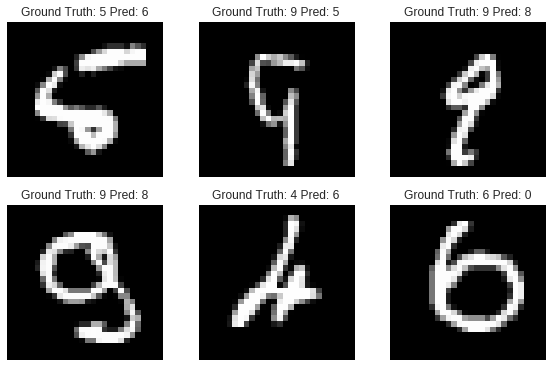

In [187]:
printIncorrect(lambda x: model_c(model_f(x)), test_set)

In [188]:
testDomainModel(model_f, model_c, device, mnist_m_test_loader)


Test set: Average loss: 0.9210, Accuracy: 7025/10000 (70%)



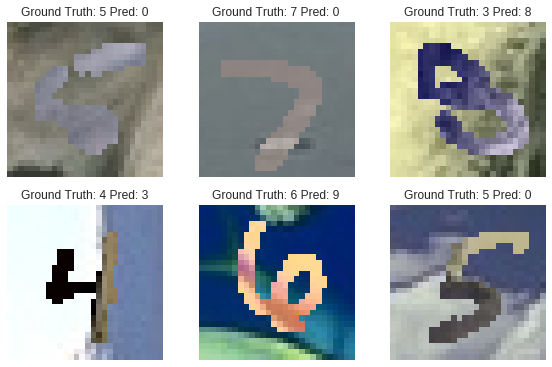

In [189]:
printIncorrect(lambda x: model_c(model_f(x)), mnist_m_test)

In [0]:
def trainDomain(model_f, model_d, device, train_loader, optimizer, epoch):
  model_d.train()
  model_f.eval()
  for batch_idx, (data, (_, domains)) in enumerate(train_loader):
    data, domains = data.to(device), domains.unsqueeze(1).to(device)
    optimizer.zero_grad()
    output = model_d(model_f(data))
    loss = criterion_domain(output, domains)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
  model_f.zero_grad()

In [0]:
class Domain(nn.Module):
  def __init__(self):
    super(Domain, self).__init__()
    self.fc1 = nn.Linear(320, 100)
    self.fc2 = nn.Linear(100, 1)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return torch.sigmoid(x)

In [192]:
domain_pred = Domain().to(device)
lr = 0.01
optim_domain = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)
for epoch in range(1, epochs+1):
  trainDomain(model_f, domain_pred, device, mnist_ext_train_loader, optim_domain, epoch)
  testWithDomain(model_f, model_c, domain_pred, device, mnist_ext_test_loader)

Train Epoch: 1 [0/120000 (0%)]	Loss: 0.765312
Train Epoch: 1 [6400/120000 (5%)]	Loss: 0.558754
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.360694
Train Epoch: 1 [19200/120000 (16%)]	Loss: 0.505778
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.286678
Train Epoch: 1 [32000/120000 (27%)]	Loss: 0.384054
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.455518
Train Epoch: 1 [44800/120000 (37%)]	Loss: 0.340341
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.362185
Train Epoch: 1 [57600/120000 (48%)]	Loss: 0.181215
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.282134
Train Epoch: 1 [70400/120000 (59%)]	Loss: 0.401666
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.290358
Train Epoch: 1 [83200/120000 (69%)]	Loss: 0.282727
Train Epoch: 1 [89600/120000 (75%)]	Loss: 0.415583
Train Epoch: 1 [96000/120000 (80%)]	Loss: 0.221683
Train Epoch: 1 [102400/120000 (85%)]	Loss: 0.145821
Train Epoch: 1 [108800/120000 (91%)]	Loss: 0.162805
Train Epoch: 1 [115200/120000 (96%)]	Loss: 0.322857

Test set: Average loss: 0.4876, Ac

In [193]:
testWithDomain(model_f, model_c, domain_pred, device, mnist_ext_test_loader)
testWithDomain(model_f, model_c, model_d, device, mnist_ext_test_loader)


Test set: Average loss: 0.4876, Accuracy: 16847/20000 (84%)

Domains: Test set:  Accuracy: 18846/20000 (94%)


Test set: Average loss: 0.4876, Accuracy: 16847/20000 (84%)

Domains: Test set:  Accuracy: 12978/20000 (65%)



In [0]:
class alwaysOne(nn.Module):
  def __init__(self):
    super(alwaysOne, self).__init__()
    self.fc2 = nn.Linear(320, 1)

  def forward(self, x):
    return torch.ones(x.shape[0]).to(device)

In [0]:
ones = alwaysOne().to(device)

In [182]:
testWithDomain(model_f, model_c, ones, device, mnist_ext_test_loader)


Test set: Average loss: 0.8648, Accuracy: 13776/20000 (69%)

Domains: Test set:  Accuracy: 10000/20000 (50%)

